# MIDS W18 Final Project Lab Notebook
### Lisa Minas
### Jay Cordes
### Scott Marler

This notebook was constructed separately in sections by Lisa, Jay, and Scott. The sections correspond with the
questions we asked in our project proposal and were started from a base notebook that contained the data imports
and initial dataframe manipulation.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
pd.options.display.float_format = '{:.2f}'.format

## Read in data files and parse dates

## Google Drive storage location for date-limited data files:
https://drive.google.com/open?id=0B_PnWx1pRhmzNWxYNDVjWjBNcnc

crime_df source data:
https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2

weather_df source data:
www.wunderground.com/history

[astronomics] ---not yet a part of this base file; please update with how it's being used
http://aa.usno.navy.mil/data/index.php

In [2]:
# Make sure data files are in the same folder
# Add any additional read-in statements here
# This takes a while because of the datetime conversion in crime_df (over a million lines)

weather_df = pd.read_csv("Chicago Weather Data 2011-2015.txt")
weather_df.rename(columns={'CST':'Date'}, inplace=True)
weather_df['Date'] = pd.to_datetime(weather_df['Date']).dt.date

crime_df = pd.read_csv("Chicago Crime 2011-2015.csv")
crime_df['Date'] = pd.to_datetime(crime_df['Date']).dt.date

## weather_df modifications

Since weather_df is already organized as a single day for every line, it is useful to add columns that will make
further analysis easier.

In [3]:
# Some columns in weather_df get imported with a leading space
# This removes those spaces

newcols = []
for i in weather_df.columns:
    if i[0] == ' ':
        i = i[1:]
    newcols.append(i)

weather_df.columns = newcols

In [4]:
# Mapping function so that temps can be categorized into buckets
def temp_map(temp):
    if temp < 0:
        return 'below 0'
    else:
        return str((temp//10)*10) + 's'
    
# Apply map to new column
weather_df['temp bucket'] = weather_df['Max TemperatureF'].map(temp_map)

In [5]:
# weatherunderground uses a scale of 0 to 9 to represent cloud cover
# I'm saying that a "clear" day is one with a cloud cover of less than 3
weather_df['Clear'] = weather_df['CloudCover'].map(lambda x: int(x) < 3)

In [6]:
# Create a list of each unique weather event type
eventlist = list(weather_df['Events'].unique())
neweventlist = []
for i in eventlist:
    i = str(i)
    neweventlist.append(i.split('-'))
eventlist = []
for i in neweventlist:
    for j in i:
        if j != 'nan':
            eventlist.append(j)
eventlist = list(set(eventlist))

# Create a new column in the weather dataframe for each item in the event list and populate with True or False for each day
for e in eventlist:
    weather_df[e] = weather_df['Events'].map(lambda x: e in str(x))

In [7]:
# Crimes per day seems like a pretty good thing to throw in there
dailycounts = crime_df.groupby('Date').size()
weather_df['crimes'] = weather_df.Date.map(lambda x: dailycounts[x])

In [8]:
# A 'local' average is useful for picking out days that deviate from their immediately adjacent neighbors
# The local deviation is how each day compares to its neighbors
def get_local_avg(date,span=7,df=weather_df):
    return df[(df['Date'] < date + datetime.timedelta(days=span/2)) & 
              (df['Date'] > date - datetime.timedelta(days=span/2)) &
              (df['Date'] != date)]['crimes'].mean()

weather_df['localavg'] = weather_df.Date.map(get_local_avg)
weather_df['localdeviation'] = weather_df['crimes']/weather_df['localavg'] - 1

In [9]:
# It's useful to be able to reference the day of the month readily
weather_df['day'] = weather_df.Date.map(lambda x: x.day)

In [10]:
# It's also useful to know which day of the week it is
weather_df['dow'] = weather_df.Date.map(lambda x: x.weekday())

## Merge DataFrames

In [11]:
# Left-join crime and weather dataframes (crime on the left)
# We are able to merge on the date because the date field in both dataframes was groomed the same way above
combined = pd.merge(crime_df, weather_df, how='left', on='Date')

In [12]:
combined.columns

Index(['Date', 'Block', 'Primary Type', 'Description', 'Location Description',
       'Arrest', 'Domestic', 'District', 'FBI Code', 'Max TemperatureF',
       'Mean TemperatureF', 'Min TemperatureF', 'Max Dew PointF',
       'MeanDew PointF', 'Min DewpointF', 'Max Humidity', 'Mean Humidity',
       'Min Humidity', 'Max Sea Level PressureIn', 'Mean Sea Level PressureIn',
       'Min Sea Level PressureIn', 'Max VisibilityMiles',
       'Mean VisibilityMiles', 'Min VisibilityMiles', 'Max Wind SpeedMPH',
       'Mean Wind SpeedMPH', 'Max Gust SpeedMPH', 'PrecipitationIn',
       'CloudCover', 'Events', 'WindDirDegrees', 'temp bucket', 'Clear',
       'Snow', 'Thunderstorm', 'Fog', 'Rain', 'Hail', 'crimes', 'localavg',
       'localdeviation', 'day', 'dow'],
      dtype='object')

# 1) Is crime more likely in warm or cold weather?

(Scott)

In [13]:
# Let's build a dataframe to start looking at each temperature bucket

temp_bucket_df_index = ['below 0', '0s', '10s', '20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s', '100s']
temp_bucket_df_columns = ['Day Count', 'Crime Rate']
temp_bucket_df = pd.DataFrame(index=temp_bucket_df_index, columns=temp_bucket_df_columns)

temp_bucket_df.head(1)

,Day Count,Crime Rate
below 0,NaN,NaN


In [14]:
# A few mapping functions will allow us to populate the counts and rates for each bucket

def daycount(bucket,event='',col='temp bucket',df=weather_df):
    '''Pass in a temperature bucket to receive back the number of days with a matching high temp.
    By using the optional event input, you can specify a second criteria'''
    
    if event == '':
        return len(df[df[col] == bucket])
    else:
        return len(df[(df[col] == bucket) & (df[event])])
    
def crimerate(bucket,event='',days_func=daycount,col='temp bucket',df=combined):
    '''Pass in a temperature bucket to receive back the crime rate for that given temp range.
    As with daycount, an event may be specified to further define the criteria.
    This function relies on the daycount function to find the denomiator for the rate calculation'''
    
    if days_func(bucket,event) == 0:
        return np.nan
    if event == '':
        return len(df[df[col] == bucket]) / days_func(bucket)
    else:
        return len(df[(df[col] == bucket) & (df[event])]) / days_func(bucket,event)

In [15]:
# Apply the mapping functions above to start getting actual data into the new dataframe
temp_bucket_df.index.name = 'Temp Bucket'
temp_bucket_df['Day Count'] = temp_bucket_df.index.map(daycount)
temp_bucket_df['Crime Rate'] = temp_bucket_df.index.map(crimerate)

In [16]:
temp_bucket_df[['Day Count','Crime Rate']].head()

,Day Count,Crime Rate
Temp Bucket,,
below 0,1,363.00
0s,8,547.00
10s,45,620.31
20s,117,702.21
30s,226,751.54


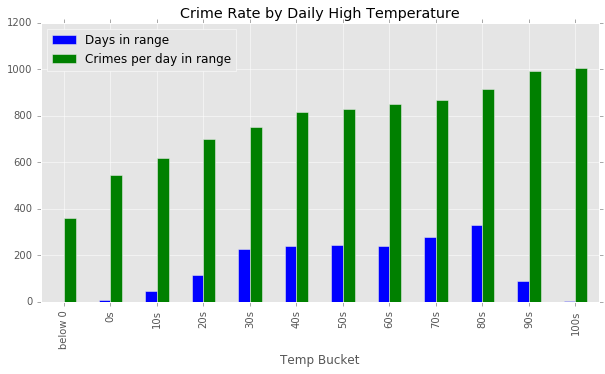

In [17]:
plt.style.use('ggplot')
temp_bucket_df[['Day Count', 'Crime Rate']].plot(kind='bar', title='Crime Rate by Daily High Temperature', 
                    figsize=(10,5)).legend(['Days in range','Crimes per day in range'], loc='upper left')

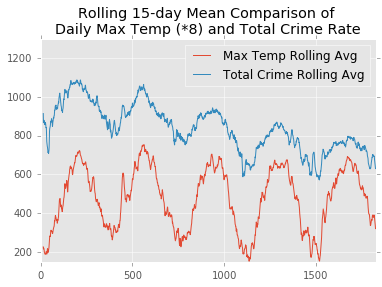

In [18]:
# Mean temp multiplied by 8 only so that the graphs appear close to eachother when plotted together
pd.rolling_mean(weather_df['Max TemperatureF'] * 8, 15).plot()
pd.rolling_mean(weather_df['crimes'], 15).plot()
plt.ylim((150, 1300))
plt.legend(['Max Temp Rolling Avg', 'Total Crime Rolling Avg'])
plt.title('Rolling 15-day Mean Comparison of \nDaily Max Temp (*8) and Total Crime Rate')

# 2) Is crime more likely during pleasant or stormy weather?

(Scott)

### In order to talk about the effects of certain weather conditions, we must define "effect"!

The effect of a weather event, as used in our analysis, is given by:

$$(\frac{e}{ne} - 1) * 100        $$

Where e is the crime rate for days on which that event occurred and ne is the is the crime rate for days on which that event did not occur.

In [19]:
# Gathering basic info - total number of days in dataset and the number of days on which each event type occurred

days = len(weather_df)

# Can filter by simply calling the column, since each of the event columns contains a True or a False
daycounts = {
    'Thunderstorm': len(weather_df[weather_df['Thunderstorm']]),
    'Hail': len(weather_df[weather_df['Hail']]),
    'Snow': len(weather_df[weather_df['Snow']]),
    'Rain': len(weather_df[weather_df['Rain']]),
    'Fog': len(weather_df[weather_df['Fog']]),
    'Clear': len(weather_df[weather_df['Clear']])
    }
print(days)
print(daycounts)

1826
{'Snow': 273, 'Thunderstorm': 191, 'Fog': 93, 'Clear': 293, 'Rain': 608, 'Hail': 3}


In [20]:
# Plucking out the frequency of each primary crime type (rate) for the presence or absense of each event type
# This is just putting together the "e" and "ne" components of the effect formula above

freq_no_thunder = combined[combined['Thunderstorm'] == False].groupby('Primary Type')['Date'].count()/(days - daycounts['Thunderstorm'])
freq_yes_thunder = combined[combined['Thunderstorm'] == True].groupby('Primary Type')['Date'].count()/daycounts['Thunderstorm']

freq_no_hail = combined[combined['Hail'] == False].groupby('Primary Type')['Date'].count()/(days - daycounts['Hail'])
freq_yes_hail = combined[combined['Hail'] == True].groupby('Primary Type')['Date'].count()/daycounts['Hail']

freq_no_snow = combined[combined['Snow'] == False].groupby('Primary Type')['Date'].count()/(days - daycounts['Snow'])
freq_yes_snow = combined[combined['Snow'] == True].groupby('Primary Type')['Date'].count()/daycounts['Snow']

freq_no_rain = combined[combined['Rain'] == False].groupby('Primary Type')['Date'].count()/(days - daycounts['Rain'])
freq_yes_rain = combined[combined['Rain'] == True].groupby('Primary Type')['Date'].count()/daycounts['Rain']

freq_no_fog = combined[combined['Fog'] == False].groupby('Primary Type')['Date'].count()/(days - daycounts['Fog'])
freq_yes_fog = combined[combined['Fog'] == True].groupby('Primary Type')['Date'].count()/daycounts['Fog']

freq_not_clear = combined[combined['Clear'] == False].groupby('Primary Type')['Date'].count()/(days - daycounts['Clear'])
freq_clear = combined[combined['Clear'] == True].groupby('Primary Type')['Date'].count()/(daycounts['Clear'])

In [21]:
# Building mini dataframes for each event and applying the calculation

thunder_comparison = pd.concat([freq_no_thunder, freq_yes_thunder],axis=1)
thunder_comparison.columns=['no thunder','thunder']
thunder_comparison['thunder effect'] = ((thunder_comparison['thunder'] / thunder_comparison['no thunder']) - 1) * 100

hail_comparison = pd.concat([freq_no_hail, freq_yes_hail],axis=1)
hail_comparison.columns=['no hail','hail']
hail_comparison['hail effect'] = ((hail_comparison['hail'] / hail_comparison['no hail']) - 1) * 100

snow_comparison = pd.concat([freq_no_snow, freq_yes_snow],axis=1)
snow_comparison.columns=['no snow','snow']
snow_comparison['snow effect'] = ((snow_comparison['snow'] / snow_comparison['no snow']) - 1) * 100

rain_comparison = pd.concat([freq_no_rain, freq_yes_rain],axis=1)
rain_comparison.columns=['no rain','rain']
rain_comparison['rain effect'] = ((rain_comparison['rain'] / rain_comparison['no rain']) - 1) * 100

fog_comparison = pd.concat([freq_no_fog, freq_yes_fog],axis=1)
fog_comparison.columns=['no fog','fog']
fog_comparison['fog effect'] = ((fog_comparison['fog'] / fog_comparison['no fog']) - 1) * 100

clear_comparison = pd.concat([freq_not_clear, freq_clear],axis=1)
clear_comparison.columns=['not clear','clear']
clear_comparison['clear effect'] = ((clear_comparison['clear'] / clear_comparison['not clear']) - 1) * 100

In [22]:
# Putting it all together
# hail_comparison['hail effect'] removed because there are only 3 days with hail - too insignificant
comparison_df = pd.concat([thunder_comparison['thunder effect'], clear_comparison['clear effect'], 
                          rain_comparison['rain effect'], fog_comparison['fog effect'],
                          snow_comparison['snow effect']], axis = 1)

In [23]:
# Building a dictionary to capture the 'sample size' for each primary type to help restrict findings
# to those that are significant
primary_types = list(combined['Primary Type'].unique())
type_counts = {}
for i in primary_types:
    type_counts[i] = len(combined[combined['Primary Type'] == i])
    
# Add the sample size values from above into its own column so it can be sorted in descending order
# (Most frequent crime on top)
comparison_df['sample size'] = comparison_df.index.map(lambda x: type_counts[x])
comparison_df.sort_values(by='sample size', ascending=[1], inplace=True)

# Just naming the index column so that it auto-populates the axis label in the plot
comparison_df.index.names = ['Primary Type']

In [24]:
# New instance of the comparison DF ommitting anything with a 'small' sample size
comparison_df_truncated = comparison_df[comparison_df['sample size'] > 1000]

In [25]:
comparison_df_truncated.index

Index(['KIDNAPPING', 'ARSON', 'HOMICIDE', 'LIQUOR LAW VIOLATION', 'GAMBLING',
       'SEX OFFENSE', 'INTERFERENCE WITH PUBLIC OFFICER',
       'CRIM SEXUAL ASSAULT', 'PROSTITUTION', 'OFFENSE INVOLVING CHILDREN',
       'PUBLIC PEACE VIOLATION', 'WEAPONS VIOLATION', 'CRIMINAL TRESPASS',
       'ROBBERY', 'MOTOR VEHICLE THEFT', 'DECEPTIVE PRACTICE', 'OTHER OFFENSE',
       'ASSAULT', 'BURGLARY', 'NARCOTICS', 'CRIMINAL DAMAGE', 'BATTERY',
       'THEFT'],
      dtype='object', name='Primary Type')

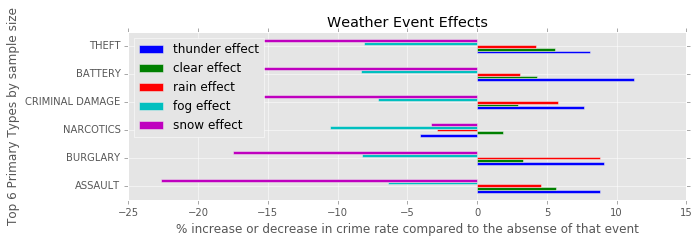

In [69]:
## Only give top 6
columns = [column for column in comparison_df_truncated.columns if column != 'sample size']
comparison_df_truncated[columns].tail(6).plot(kind='barh', figsize=(10,3), 
                                      title='Weather Event Effects')
plt.xlabel('% increase or decrease in crime rate compared to the absense of that event')
plt.ylabel('Top 6 Primary Types by sample size')
plt.legend(loc='upper left')

### Interesting! It appears as though Thunderstorms and Clear Weather are both associated with an increase in crime rate, while Fog and Snow seem to have the opposite association

In [27]:
comparison_df.describe()

,thunder effect,clear effect,rain effect,fog effect,snow effect,sample size
count,32.00,32.00,32.00,30.00,32.00,33.00
mean,13.36,14.92,2.78,-3.79,-20.30,46305.30
std,28.53,39.81,6.78,23.52,20.91,81279.83
min,-23.91,-40.54,-9.75,-37.89,-88.64,3.00
25%,0.90,1.23,-2.17,-14.77,-24.31,697.00
50%,4.95,5.56,1.85,-8.08,-16.60,6263.00
75%,11.73,12.49,5.80,-3.44,-8.23,68470.00
max,105.45,185.39,26.52,86.34,8.72,340766.00


It now appears as though both temperature and weather events have definite associations with crime rates. However, weather events themselves tend to be associated with certain temperatures. So we need to tease out the event effects from <b>within</b> each temperature range.

Thunderstorms, in particular, seem counterintuitive. How can it be that crime is more likely when there's a thunderstorm?

In [28]:
# What sort of temperature is common during a thunderstorm?
print('Average high temp on thunderstorm days','{:.2f}'.format(combined[combined['Thunderstorm'] == True]['Max TemperatureF'].mean()))
print('Average high temp on non-thunderstorm days','{:.2f}'.format(combined[combined['Thunderstorm'] == False]['Max TemperatureF'].mean()))

Average high temp on thunderstorm days 77.46
Average high temp on non-thunderstorm days 59.32


In [29]:
# Let's build on to the temp_bucket_df we built previously

temp_bucket_df['Clear Days'] = temp_bucket_df.index.map(lambda x: daycount(x,'Clear'))
temp_bucket_df['Clear Rate'] = temp_bucket_df.index.map(lambda x: crimerate(x,'Clear'))

for event in eventlist:
    temp_bucket_df[str(event) + ' Days'] = temp_bucket_df.index.map(lambda x: daycount(x,event))
    temp_bucket_df[str(event) + ' Rate'] = temp_bucket_df.index.map(lambda x: crimerate(x,event))

In [30]:
temp_bucket_df['Clear Effect'] = ((temp_bucket_df['Clear Rate'] / temp_bucket_df['Crime Rate'])-1)*100
for event in eventlist:
    temp_bucket_df[str(event) + ' Effect'] = ((temp_bucket_df[str(event) + ' Rate'] / temp_bucket_df['Crime Rate'])-1)*100
# temp_bucket_df['Temp Effect'] = ((temp_bucket_df['Crime Rate'] / overall)-1)*100
# temp_bucket_df

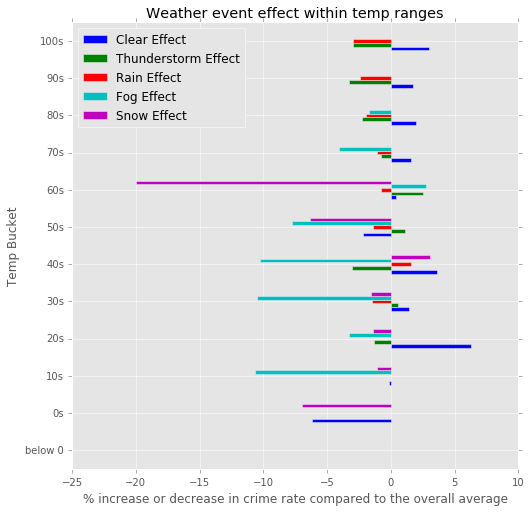

In [31]:
plt.style.use('ggplot')
temp_bucket_df[(['Clear Effect', 'Thunderstorm Effect', 
                 'Rain Effect', 'Fog Effect', 
                 'Snow Effect'])].plot(kind = 'barh', figsize = (8,8),
                                       title = 'Weather event effect within temp ranges')
plt.xlabel('% increase or decrease in crime rate compared to the overall average')

### A much different story indeed

We can now see that for every weather event <i>within</i> each temperature range, there is almost always
a negative association between weather events and overall crime rate.

Thunderstorms looked like they caused a spike in crime, but it's only because thunderstorms happen
in warmer than average temperatures.

"Clear" days, which were defined as having cloud cover ratings less than 3, are consistently associated with 
higher crime rates, even within a given temperature range.

# 3) Are certain phases of the moon related to higher crime rates?

(Lisa)

# 4) Which criminal activities become more or less likely during specific weather events?

(Scott)

Earlier, we looked at how weather events affect crime rates, but that was without adjusting for temperature. We've learned that temperature really is the driving factor for overall crime rate. But are there particular crime types that become *more* likely for a particular weather event within a certain temperature range?

In [32]:
combined['Date'] = pd.to_datetime(combined['Date']).dt.date

In [33]:
len(combined.groupby(['Date','Primary Type']).get_group((combined.Date[0],'THEFT')))

132

In [34]:
# This groupby will be used repeatedly in the daily_type_map formula below. Storing it in memory
# so that the groupby operation doesn't have to be run over and over again (several thousand times)
grouped = combined.groupby(['Date', 'Primary Type']).Block.count()


In [35]:
sorted_types = comparison_df_truncated.index[::-1]
sorted_types

Index(['THEFT', 'BATTERY', 'CRIMINAL DAMAGE', 'NARCOTICS', 'BURGLARY',
       'ASSAULT', 'OTHER OFFENSE', 'DECEPTIVE PRACTICE', 'MOTOR VEHICLE THEFT',
       'ROBBERY', 'CRIMINAL TRESPASS', 'WEAPONS VIOLATION',
       'PUBLIC PEACE VIOLATION', 'OFFENSE INVOLVING CHILDREN', 'PROSTITUTION',
       'CRIM SEXUAL ASSAULT', 'INTERFERENCE WITH PUBLIC OFFICER',
       'SEX OFFENSE', 'GAMBLING', 'LIQUOR LAW VIOLATION', 'HOMICIDE', 'ARSON',
       'KIDNAPPING'],
      dtype='object', name='Primary Type')

In [36]:
def daily_type_map(d,t,s=grouped):
    try:
        return s[d][t]
    except KeyError:
        return 0
        

In [37]:
for i in sorted_types:
    weather_df[i] = weather_df.Date.map(lambda x: daily_type_map(x,i))

In [38]:
weather_df.head()

,Date,Max TemperatureF,Mean TemperatureF,Min TemperatureF,Max Dew PointF,MeanDew PointF,Min DewpointF,Max Humidity,Mean Humidity,Min Humidity,...,OFFENSE INVOLVING CHILDREN,PROSTITUTION,CRIM SEXUAL ASSAULT,INTERFERENCE WITH PUBLIC OFFICER,SEX OFFENSE,GAMBLING,LIQUOR LAW VIOLATION,HOMICIDE,ARSON,KIDNAPPING
0,2011-01-01,41,28,14,30,12,3,76,63,49,...,68,2,33,2,34,0,8,2,2,2
1,2011-01-02,24,18,12,14,8,4,76,60,44,...,3,1,5,0,1,0,0,2,1,0
2,2011-01-03,36,29,22,23,18,15,78,63,47,...,2,4,2,3,2,1,2,0,3,2
3,2011-01-04,30,22,13,22,13,5,81,70,59,...,6,7,7,3,2,0,1,2,5,2
4,2011-01-05,31,20,8,25,14,4,83,68,53,...,7,9,3,2,2,1,0,0,0,0


In [39]:
templist = []
for t in temp_bucket_df_index:
    for e in eventlist:
        for s in sorted_types:
            factor = (weather_df[(weather_df[e] == True) & (weather_df['temp bucket'] == t)][s].sum()/\
                      weather_df[(weather_df[e] == True) & (weather_df['temp bucket'] == t)][s].count())/\
            (weather_df[(weather_df[e] == False) & (weather_df['temp bucket'] == t)][s].sum()/\
             weather_df[(weather_df[e] == False) & (weather_df['temp bucket'] == t)][s].count())
            if weather_df[(weather_df[e] == True) & (weather_df['temp bucket'] == t)][s].count() > 25 and factor > 1.05:
                templist.append(s)
tempseries = pd.Series(templist)


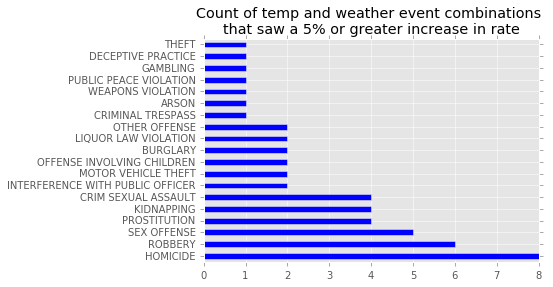

In [40]:
tempseries.value_counts().plot(kind='barh', title='Count of temp and weather event combinations \nthat saw a 5% or greater increase in rate')

It does indeed appear as though Kidnapping, Prostitution, Criminal Sexual Assault, Sex Offense, Robbery, and Homocide become more likely as the weather becomes less pleasant (corrected for temperature). Interesting.

# 5) Is crime influenced more by weather or by season?

(Lisa)

# 6) Is crime less likely to occur on holidays?

(Jay)

So, the thought here is similar to the "fewer crimes during bad weather" hypothesis. People are usually hanging out with their family on Xmas and Thanksgiving, for example, and are less likely to be breaking into houses. Initially, I just plotted the holidays against the average crime per day and it did show a decrease. However, Scott brought up a great question: how do we know that these days don't just have fewer crimes since they're generally in the colder months (temperature being a confounding variable). To address that question, I compared the holiday arrest average against the average number of arrests in the surrounding days see if the decrease was still there. It was!

In [41]:
# Total Crimes
total_crimes = len(combined)
print(total_crimes)

1528075


In [42]:
# of days in the dataset
numdays = len(weather_df.Date)
print(numdays)

1826


In [43]:
# Avg number of crimes per day in Chicago
print(total_crimes / numdays)

836.84282584885


In [44]:
# Created a dataframe of crime grouped by date
crime_by_day = pd.DataFrame(combined.groupby("Date").size())

# Got the date out of the index, because I find the inconsistencies
# between dealing with the index and a column to be annoying.
crime_by_day = crime_by_day.reset_index()
crime_by_day.columns = ['Date', 'Count']

# Made lists of the dates for each of the holidays
xmas_dates = [datetime.date(2011, 12, 25), datetime.date(2012, 12, 25),
              datetime.date(2013, 12, 25), datetime.date(2014, 12, 25),
              datetime.date(2015, 12, 25)]

tg_dates = [datetime.date(2011, 11, 24), datetime.date(2012, 11, 22),
            datetime.date(2013, 11, 28), datetime.date(2014, 11, 27),
            datetime.date(2015, 11, 26)]

nye_dates = [datetime.date(2011, 12, 31), datetime.date(2012, 12, 31),
             datetime.date(2013, 12, 31), datetime.date(2014, 12, 31),
             datetime.date(2015, 12, 31)]

e_dates = [datetime.date(2011, 4, 24), datetime.date(2012, 4, 8),
           datetime.date(2013, 3, 31), datetime.date(2014, 4, 20),
           datetime.date(2015, 4, 5)]

# Calculated the average crime per day for each of the holidays
avgxmas = (crime_by_day[(crime_by_day["Date"] == xmas_dates[0]) |
                        (crime_by_day["Date"] == xmas_dates[1]) |
                        (crime_by_day["Date"] == xmas_dates[2]) |
                        (crime_by_day["Date"] == xmas_dates[3]) |
                        (crime_by_day["Date"] == xmas_dates[4])].mean().item())

avgtg = (crime_by_day[(crime_by_day["Date"] == tg_dates[0]) |
                      (crime_by_day["Date"] == tg_dates[1]) |
                      (crime_by_day["Date"] == tg_dates[2]) |
                      (crime_by_day["Date"] == tg_dates[3]) |
                      (crime_by_day["Date"] == tg_dates[4])].mean().item())

avgny = (crime_by_day[(crime_by_day["Date"] == nye_dates[0]) |
                      (crime_by_day["Date"] == nye_dates[1]) |
                      (crime_by_day["Date"] == nye_dates[2]) |
                      (crime_by_day["Date"] == nye_dates[3]) |
                      (crime_by_day["Date"] == nye_dates[4])].mean().item())

avge = (crime_by_day[(crime_by_day["Date"] == e_dates[0]) |
                     (crime_by_day["Date"] == e_dates[1]) |
                     (crime_by_day["Date"] == e_dates[2]) |
                     (crime_by_day["Date"] == e_dates[3]) |
                     (crime_by_day["Date"] == e_dates[4])].mean().item())


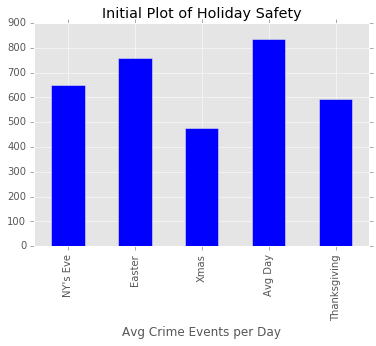

In [45]:
# The initial plot of average holiday crime vs. avg daily crime
# dicts rearrange things, so I used a list the next time around
plt.style.use('ggplot')
holidays_dict = {}
holidays_dict["Avg Day"] = total_crimes / numdays
holidays_dict["Xmas"] = avgxmas
holidays_dict["Thanksgiving"] = avgtg
holidays_dict["NY's Eve"] = avgny
holidays_dict["Easter"] = avge

holidays_df = pd.DataFrame.from_dict(holidays_dict, orient="index")
holidays_df.index.names = ['Avg Crime Events per Day']
holidays_df.plot(kind="bar", title='Initial Plot of Holiday Safety',
                 legend=False)

In [46]:
def grabcrime(year, month, day, df):
    ''' This takes in a dataframe and a date and returns the
        number of arrests that day.
    '''

    return df[df["Date"] == datetime.date(
            year, month, day)]["Count"].item()

# Track total crime around XMas
a_xmas_totals = 0

for y in [2011, 2012, 2013, 2014, 2015]:
    for d in [22, 23, 24, 26, 27, 28]:
        a_xmas_totals += grabcrime(y, 12, d, crime_by_day)

# I thought about trying to avoid this repetitive code
# but it's easy to read and understand.

a_tg_totals = 0

a_tg_totals += grabcrime(2011, 11, 21, crime_by_day)
a_tg_totals += grabcrime(2011, 11, 22, crime_by_day)
a_tg_totals += grabcrime(2011, 11, 23, crime_by_day)
a_tg_totals += grabcrime(2011, 11, 25, crime_by_day)
a_tg_totals += grabcrime(2011, 11, 26, crime_by_day)
a_tg_totals += grabcrime(2011, 11, 27, crime_by_day)

a_tg_totals += grabcrime(2012, 11, 19, crime_by_day)
a_tg_totals += grabcrime(2012, 11, 20, crime_by_day)
a_tg_totals += grabcrime(2012, 11, 21, crime_by_day)
a_tg_totals += grabcrime(2012, 11, 23, crime_by_day)
a_tg_totals += grabcrime(2012, 11, 24, crime_by_day)
a_tg_totals += grabcrime(2012, 11, 25, crime_by_day)

a_tg_totals += grabcrime(2013, 11, 25, crime_by_day)
a_tg_totals += grabcrime(2013, 11, 26, crime_by_day)
a_tg_totals += grabcrime(2013, 11, 27, crime_by_day)
a_tg_totals += grabcrime(2013, 11, 29, crime_by_day)
a_tg_totals += grabcrime(2013, 11, 30, crime_by_day)
a_tg_totals += grabcrime(2013, 12, 1, crime_by_day)

a_tg_totals += grabcrime(2014, 11, 24, crime_by_day)
a_tg_totals += grabcrime(2014, 11, 25, crime_by_day)
a_tg_totals += grabcrime(2014, 11, 26, crime_by_day)
a_tg_totals += grabcrime(2014, 11, 28, crime_by_day)
a_tg_totals += grabcrime(2014, 11, 29, crime_by_day)
a_tg_totals += grabcrime(2014, 11, 30, crime_by_day)

a_tg_totals += grabcrime(2015, 11, 23, crime_by_day)
a_tg_totals += grabcrime(2015, 11, 24, crime_by_day)
a_tg_totals += grabcrime(2015, 11, 25, crime_by_day)
a_tg_totals += grabcrime(2015, 11, 27, crime_by_day)
a_tg_totals += grabcrime(2015, 11, 28, crime_by_day)
a_tg_totals += grabcrime(2015, 11, 29, crime_by_day)

# Track total crime around NYE
a_nye_totals = 0

for y in [2011, 2012, 2013, 2014]:
    for d in [28, 29, 30, 1, 2, 3]:
        if d > 20:
            m = 12
            yr = y
        else:
            m = 1
            yr = y + 1

        # print("Adding", yr, m, d)
        a_nye_totals += grabcrime(yr, m, d, crime_by_day)

# We don't have data for the days following the final NYE,
# so I just grabbed the preceding 6 days
a_nye_totals += grabcrime(2015, 12, 25, crime_by_day)
a_nye_totals += grabcrime(2015, 12, 26, crime_by_day)
a_nye_totals += grabcrime(2015, 12, 27, crime_by_day)
a_nye_totals += grabcrime(2015, 12, 28, crime_by_day)
a_nye_totals += grabcrime(2015, 12, 29, crime_by_day)
a_nye_totals += grabcrime(2015, 12, 30, crime_by_day)

# Track total crime around Easter
a_easter_totals = 0

a_easter_totals += grabcrime(2011, 4, 21, crime_by_day)
a_easter_totals += grabcrime(2011, 4, 22, crime_by_day)
a_easter_totals += grabcrime(2011, 4, 23, crime_by_day)
a_easter_totals += grabcrime(2011, 4, 25, crime_by_day)
a_easter_totals += grabcrime(2011, 4, 26, crime_by_day)
a_easter_totals += grabcrime(2011, 4, 27, crime_by_day)

a_easter_totals += grabcrime(2012, 4, 5, crime_by_day)
a_easter_totals += grabcrime(2012, 4, 6, crime_by_day)
a_easter_totals += grabcrime(2012, 4, 7, crime_by_day)
a_easter_totals += grabcrime(2012, 4, 9, crime_by_day)
a_easter_totals += grabcrime(2012, 4, 10, crime_by_day)
a_easter_totals += grabcrime(2012, 4, 11, crime_by_day)

a_easter_totals += grabcrime(2013, 3, 28, crime_by_day)
a_easter_totals += grabcrime(2013, 3, 29, crime_by_day)
a_easter_totals += grabcrime(2013, 3, 30, crime_by_day)
a_easter_totals += grabcrime(2013, 4, 1, crime_by_day)
a_easter_totals += grabcrime(2013, 4, 2, crime_by_day)
a_easter_totals += grabcrime(2013, 4, 3, crime_by_day)

a_easter_totals += grabcrime(2014, 4, 17, crime_by_day)
a_easter_totals += grabcrime(2014, 4, 18, crime_by_day)
a_easter_totals += grabcrime(2014, 4, 19, crime_by_day)
a_easter_totals += grabcrime(2014, 4, 21, crime_by_day)
a_easter_totals += grabcrime(2014, 4, 22, crime_by_day)
a_easter_totals += grabcrime(2014, 4, 23, crime_by_day)

a_easter_totals += grabcrime(2015, 4, 2, crime_by_day)
a_easter_totals += grabcrime(2015, 4, 3, crime_by_day)
a_easter_totals += grabcrime(2015, 4, 4, crime_by_day)
a_easter_totals += grabcrime(2015, 4, 6, crime_by_day)
a_easter_totals += grabcrime(2015, 4, 7, crime_by_day)
a_easter_totals += grabcrime(2015, 4, 8, crime_by_day)


In [47]:
# Created a dataframe with all of the stats to plot...
holidays_list = []
holidays_list.append(("Around XMas", a_xmas_totals / 30))
holidays_list.append(("Xmas", avgxmas))
holidays_list.append(("Around Thanksgiving", a_tg_totals / 30))
holidays_list.append(("Thanksgiving", avgtg))
holidays_list.append(("Around NY's Eve", a_nye_totals / 30))
holidays_list.append(("NY's Eve", avgny))
holidays_list.append(("Around Easter", a_easter_totals / 30))
holidays_list.append(("Easter", avge))

holidays_df = pd.DataFrame.from_records(
    holidays_list, index=["Around XMas", "XMas", "Around Thanksgiving",
                          "Thanksgiving", "Around NY's Eve", "NY's Eve",
                          "Around Easter", "Easter"],
    columns=["Desc", "Crimes per Day"])


Now we're ready to chart the holidays vs. their surrounding days to see if the decrease is real or just temperature-driven.

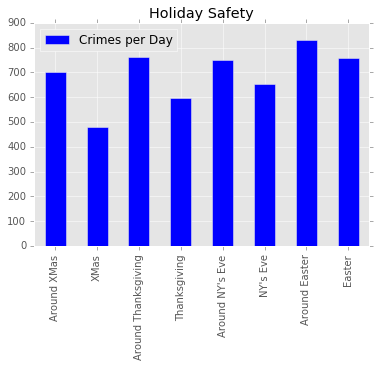

In [48]:
holidays_df.index.names = ['']
holidays_df.plot(kind="bar", title='Holiday Safety', legend=True,
                color=['b', 'b', 'r', 'r', 'g', 'g', 'y', 'y'])

# how to visually group holidays by color?

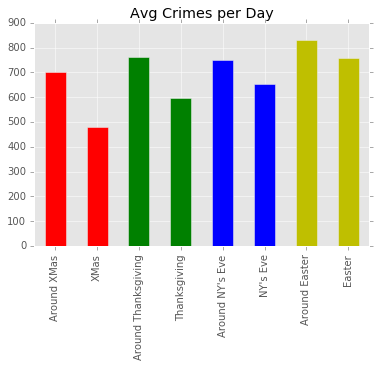

In [49]:
# For some reason, this worked...
holidays_df["group"] = [1,1,2,2,3,3,4,4]

holidays_df["Crimes per Day"].plot(kind='bar', title='Avg Crimes per Day', legend=False,
                                   color=['r', 'r', 'g', 'g', 'b', 'b', 'y', 'y'])

# 7) How has the crime rate changed over time? Is the change the same across all crime types?

(Jay)

So, despite all of the doom and gloom in the news these days, every once in awhile you hear a statistic about crime actually dropping in the last few decades. I'd even heard somewhere that it's as safe now as it was in the "golden era" when our parents were kids and people didn't lock their doors. However, I didn't know if it was continuing to drop or if it had reached a plateau. Our data covered the last five calendar years in Chicago, so we had a great opportunity to answer that question. It turns out that the answer is a big "yes, it is still dropping!"

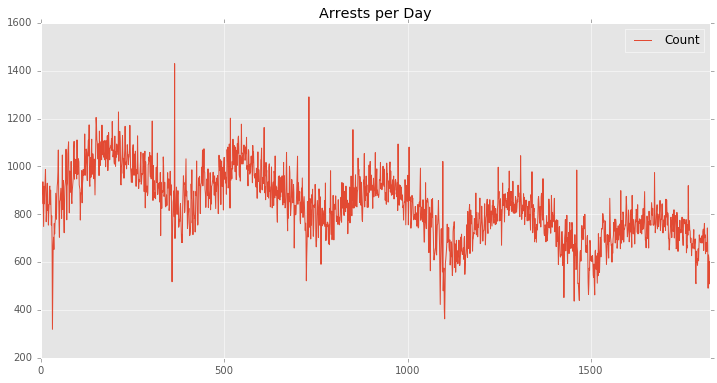

In [50]:
crime_by_day.plot(figsize=(12,6), title="Arrests per Day")

The next question is whether or not it's dropping for all types of crimes or just some of them. Or maybe just the most common crime is dropping and it's giving the aggregate the impression that overall crime is decreasing. In order to dig deeper, I looked at the top 10 most common crime types and charted them individually.

In [51]:
# Created a list of top 10 crime types
top10df = pd.DataFrame(combined["Primary Type"].value_counts().head(10))
top10df = top10df.reset_index()
top10list = list(top10df["index"].str.lower())
print("Top 10 most common crime types: ", top10list)

# Created a new column in the combined dataframe for
# each type of crime with True or False for each day
for c in top10list:
    combined[c] = combined['Primary Type'].map(
        lambda x: c in str(x).lower())

Top 10 most common crime types:  ['theft', 'battery', 'criminal damage', 'narcotics', 'burglary', 'assault', 'other offense', 'deceptive practice', 'motor vehicle theft', 'robbery']


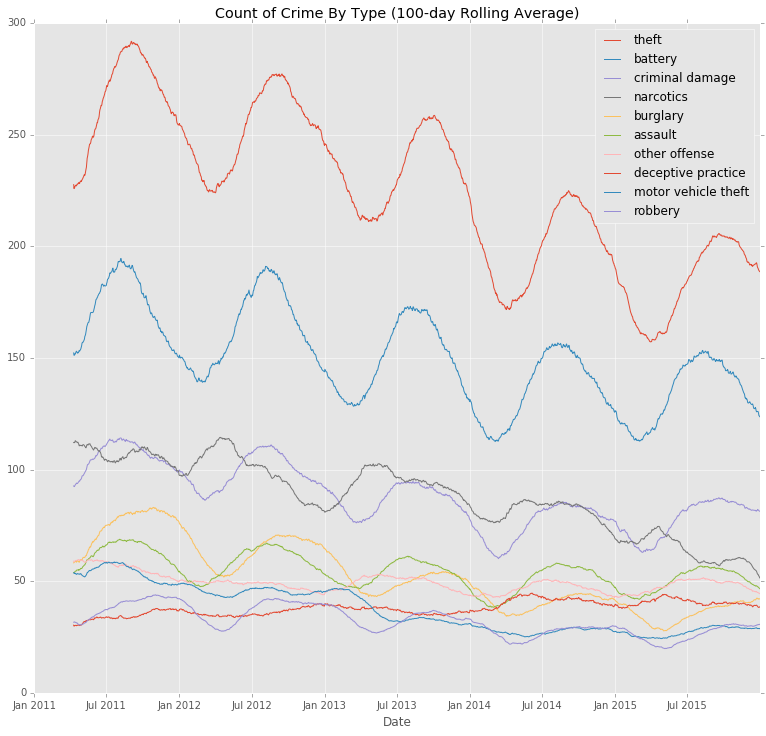

In [52]:
# Charting the arrests per day was too noisy.
# A rolling-average chart makes the downward trend more clear.
pd.rolling_mean(combined.groupby(["Date"])[top10list].sum(), 100).plot(
    figsize=(13, 12),
    title="Count of Crime By Type (100-day Rolling Average)")

So, it appears that every single type of crime in the top 10 has been dropping in the last five years, with the exception of "deceptive practice." So, what's that?

In [53]:
combined[combined["Primary Type"] == "DECEPTIVE PRACTICE"][
    "Description"].value_counts()

CREDIT CARD FRAUD                          14658
ILLEGAL USE CASH CARD                       9867
THEFT OF LABOR/SERVICES                     8829
FINANCIAL IDENTITY THEFT OVER $ 300         8091
FRAUD OR CONFIDENCE GAME                    6976
FORGERY                                     2922
COUNTERFEITING DOCUMENT                     2850
BOGUS CHECK                                 2610
FINANCIAL IDENTITY THEFT $300 AND UNDER     2590
COUNTERFEIT CHECK                           2151
THEFT OF LOST/MISLAID PROP                  1914
ATTEMPT - FINANCIAL IDENTITY THEFT           926
THEFT BY LESSEE,MOTOR VEH                    776
COMPUTER FRAUD                               534
FINAN EXPLOIT-ELDERLY/DISABLED               467
STOLEN PROP: BUY/RECEIVE/POS.                451
UNLAWFUL USE OF RECORDED SOUND               387
DECEPTIVE COLLECTION PRACTICES               374
EMBEZZLEMENT                                 274
ILLEGAL POSSESSION CASH CARD                 256
AGGRAVATED FINANCIAL

There seem to be a few other types of crime that are not following the downward trend as well. It's an interesting open question about what is different about these non-trending crime types. Answering that may shed light on why almost all of the other types are decreasing.

Unfortunately, it turns out that offenses involving children and sexual assaults are two of the types of crime that don't have a clear downward trend. It could be more due to the relatively low incident count per day in this dataset, which can make any trend hard to see. Further study with nationwide statistics could answer this question definitively.

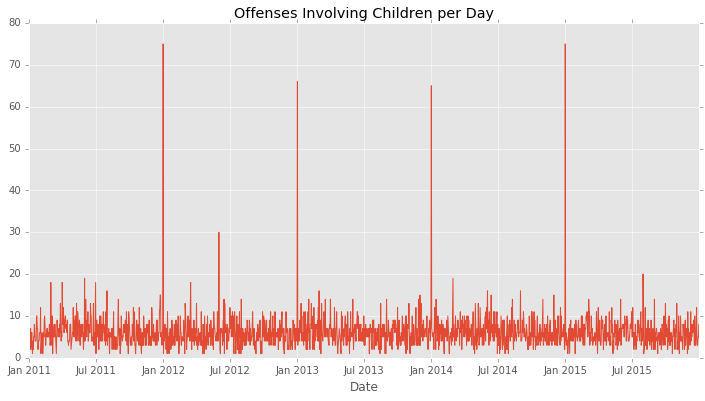

In [54]:
by_day = combined[combined['Primary Type'] ==
                  'OFFENSE INVOLVING CHILDREN'][['Date']].groupby(['Date'])
by_day_series = pd.Series(by_day.Date.count())
by_day_series.plot(figsize=(12, 6),
                   title="Offenses Involving Children per Day")

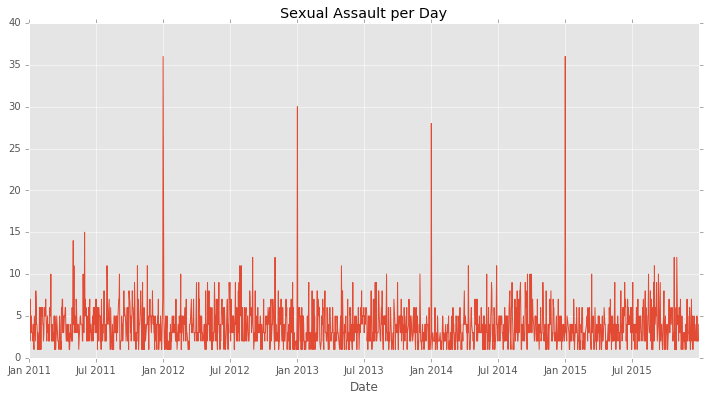

In [55]:
by_day = combined[combined['Primary Type'] == 'CRIM SEXUAL ASSAULT'][
    ['Date']].groupby(['Date'])
by_day_series = pd.Series(by_day.Date.count())
by_day_series.plot(figsize=(12, 6), title="Sexual Assault per Day")


# 8) Does the day of the month affect crime rate?

(Scott)

It may seem trivial, but it might be worth exploring how the day of the month affects the crime rate

In [56]:
types_df = pd.DataFrame(index=primary_types)
types_df['total'] = types_df.index.map(lambda x: len(combined[combined['Primary Type'] == x]))
types_df.sort_values(by='total', ascending=[0], inplace=True)

In [57]:
types_df.drop(types_df[types_df['total'] < 1000].index, axis=0, inplace=True)

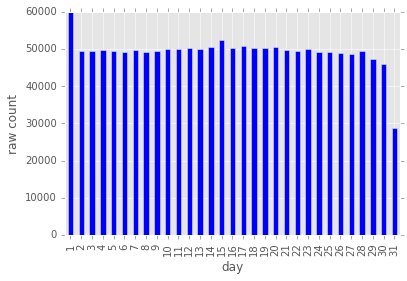

In [58]:
weather_df.groupby('day').crimes.sum().plot(kind='bar')
plt.ylabel('raw count')

Right off the bat, it looks like there's a significant spike in crime on the 1st of the month. The 31st sees a huge drop, but that's expected, given that only about half of the months have a 31st day.

The small spike on the 15th, combined with the spike on the 1st, makes me wonder if some crimes are associated with a typical salaried employee's payday.

In [59]:
# Pull crime rate for a given primary type and day of the month
def inclusivedayrate(ptype, day=1, df=combined):
    instances = len(df[(df['Primary Type'] == ptype) & (df['day'] == day)])
    days = len(df[(df['Primary Type'] == ptype) & (df['day'] == day)].Date.unique())
    return instances/days

def exclusivedayrate(ptype, day=1, df=combined):
    instances = len(df[(df['Primary Type'] == ptype) & (df['day'] != day)])
    days = len(df[(df['Primary Type'] == ptype) & (df['day'] != day)].Date.unique())
    return instances/days

In [60]:
types_df['firstrate'] = types_df.index.map(inclusivedayrate)
types_df['otherdaysrate'] = types_df.index.map(exclusivedayrate)
types_df['firstratefactor'] = (types_df['firstrate'] / types_df['otherdaysrate'] -1)*100

In [61]:
#types_df

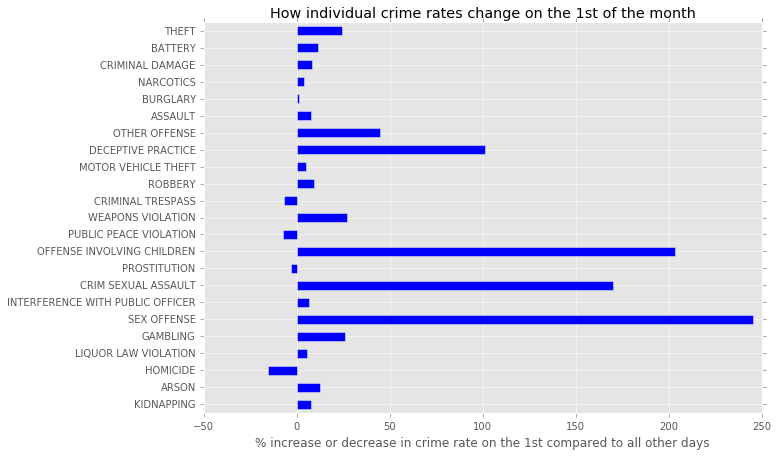

In [62]:
types_df[::-1].firstratefactor.plot(kind='barh', title='How individual crime rates change on the 1st of the month', figsize=(10,7))
plt.xlabel('% increase or decrease in crime rate on the 1st compared to all other days')

### Whoa!

There's a huge spike on the 1st of the month for nearly all crimes, but a few crimes in particular (~250% for sex offense).

Offense involving children could make sense, if we consider that disputes about child support payments could be more likely on the 1st. Descepting Practice may have something to do with swindling people out of their hard-earned paychecks.

Sexual Assault and Sex Offense, however, do not seem to have an obvious connection with the day of the month. It could be that a separate police division handles sex assault and sex offense cases and they have different practices about how cases get filed.

I've actually sent an email to the Chicago PD to ask for help understanding the spike, but have not heard back yet. If I get anything back, I'll include what I learn in this analysis.

# Sandbox
## Any other useful/relevant/interesting findings?

(Anybody)

If you watch the news, not only will you not get the impression that crime is dropping around the country, you will also think that homicide is a very common thing.  According to this article:  http://dartcenter.org/content/violence-comparing-reporting-and-reality,
the Chicago Tribune crime section in the 1980s featured murder over 25% of the time, even though it made up only 0.2% of the crimes committed.  So if the media crime coverage were actually proportional to the type of crime, what stories would we be seeing on the news every night?

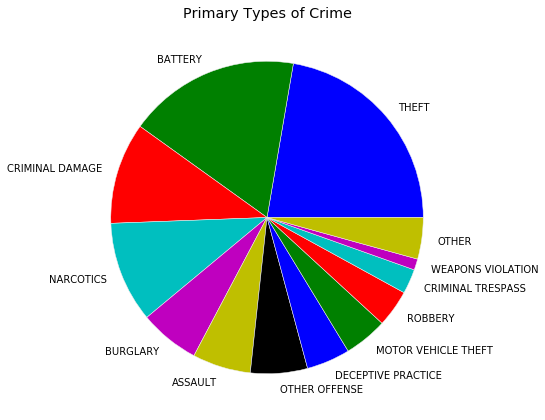

In [63]:
top_crimes = pd.DataFrame(combined["Primary Type"].value_counts() /
                          combined["Primary Type"].value_counts().sum())

remaining_pct = 1 - top_crimes[top_crimes["Primary Type"] > 0.01].sum()
other = pd.DataFrame({"Primary Type": remaining_pct.item()}, index=['OTHER'])

# Will replace tiny slices with an "other" slice
top_crimes = top_crimes.append(other)

top_crimes_for_pie = top_crimes[top_crimes["Primary Type"] > 0.01][
    "Primary Type"]

top_crimes_for_pie.name = " " # Name was showing up on the chart.

top_crimes_for_pie.plot(kind="pie", figsize=(7, 7),
                        title="Primary Types of Crime")

So, theft, battery, and criminal damage would take up fully half of the crime coverage! So, what about at a more detailed level? We all freak out about crimes like "home invasion", is it anywhere in the list?

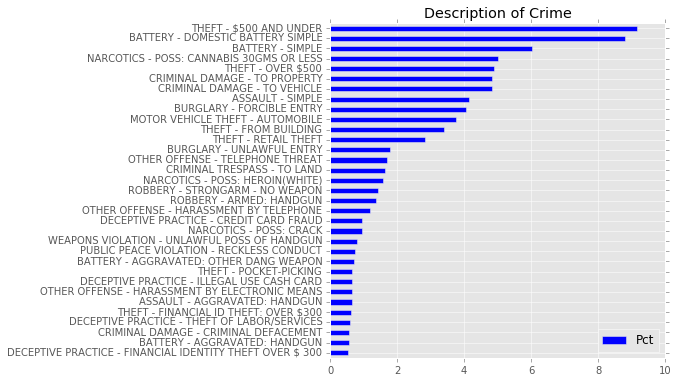

In [64]:
# Found a cool way to group by a combination of fields...
groups = combined.groupby(combined["Primary Type"] +
                          " - " + combined["Description"])

top_crimes2 = pd.DataFrame(groups.size(), columns=['Pct'])
top_crimes2 = top_crimes2.sort_values("Pct", ascending=False)

total = sum(top_crimes2.Pct)

top_crimes2 = top_crimes2 / total * 100

top_crimes2[top_crimes2.Pct > 0.5].plot(kind="barh",
                                        figsize=(6, 6),
                                        title="Description of Crime"
                                        ).invert_yaxis()


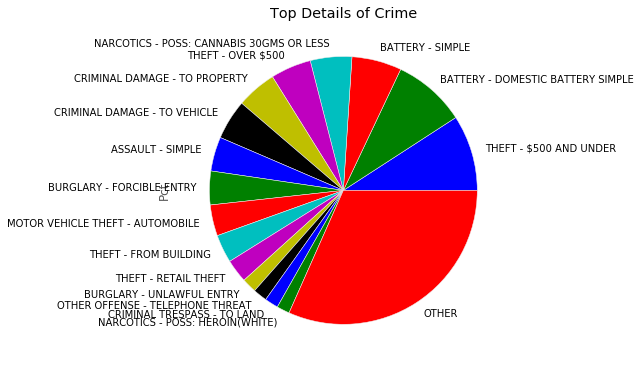

In [65]:
# Let's do it again as a pie chart...
top_crimes_for_pie = top_crimes2[top_crimes2["Pct"] > 1.5]

# if fields add up to nearly 1, pie leaves a gap for missing %
top_crimes_for_pie = top_crimes_for_pie / 100

missing_slice = pd.DataFrame({'Pct': float(1-top_crimes_for_pie.sum())},
                             index=['OTHER'])

top_crimes_for_pie = top_crimes_for_pie.append(missing_slice)

top_crimes_for_pie["Pct"].plot(kind="Pie", figsize=(6, 6),
                               title="Top Details of Crime")

In [66]:
# So where is "home invasion"??
100 * combined[combined["Description"] ==
               "HOME INVASION"]["Description"].value_counts() \
                / total_crimes

# That's not 8.5%, that's 0.085%!  Not too scary!


HOME INVASION   0.09
Name: Description, dtype: float64

In [67]:
print(pd.__version__)

0.17.1
